In [29]:
#Import modules
from pathlib import Path
import sys
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load data & Data Cleaning

In [2]:
df = pd.read_csv('../../datasets/HomeC.csv')

In [3]:
df.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

In [4]:
df.columns = [i.replace(' [kW]', '') for i in df.columns]

In [5]:
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','House overall','summary'],axis = 1,inplace = True)
df.columns

Index(['time', 'use', 'gen', 'Dishwasher', 'Home office', 'Fridge',
       'Wine cellar', 'Garage door', 'Barn', 'Well', 'Microwave',
       'Living room', 'Solar', 'temperature', 'humidity', 'visibility',
       'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability',
       'Furnace', 'Kitchen'],
      dtype='object')

In [6]:
df[df.isnull().any(axis=1)]

,time,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
503910,\,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [7]:
#remove last row as the values are NaN
df = df[0:-1] ## == dataset[0:dataset.shape[0]-1] == dataset[0:len(dataset)-1] == dataset[:-1]
df[df.isnull().any(axis=1)]

,time,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen


In [8]:
df['cloudCover'].unique()

array(['cloudCover', '0.75', '0', '1', '0.31', '0.44', '0.13', '0.19',
       '0.25', '0.16', '0.21', '0.15', '0.14', '0.27', '0.28', '0.17',
       '0.05', '0.1', '0.26', '0.29', '0.11', '0.09', '0.12', '0.06',
       '0.02', '0.08', '0.04', '0.35', '0.22', '0.23', '0.54', '0.39',
       '0.03', '0.07', '0.76', '0.62', '0.18', '0.79', '0.48', '0.24',
       '0.57', 0.24, 1.0, 0.31, 0.28, 0.15, 0.41, 0.1, 0.12, 0.08, 0.09,
       0.19, 0.04, 0.05, 0.29, 0.27, 0.35, 0.18, 0.06, 0.03, 0.11, 0.14,
       0.25, 0.78, 0.0, 0.16, 0.21, 0.23, 0.17, 0.75, 0.26, 0.2, 0.76,
       0.13, 0.77, 0.46, 0.07, 0.55, 0.02, 0.01, 0.51, 0.47, 0.5, 0.4,
       0.3, 0.22, 0.43, 0.33, 0.6, 0.68, 0.66, 0.45, 0.34, 0.52, 0.67,
       0.48, 0.49, 0.39, 0.37, 0.62, 0.36, 0.79, 0.61, 0.38, 0.42, 0.53,
       0.63, 0.44, 0.54, 0.32, 0.56, 0.58, 0.72, 0.57, 0.73, 0.71, 0.64,
       0.59], dtype=object)

In [9]:
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df['cloudCover'] = df['cloudCover'].astype('float')
df['cloudCover']

0         0.75
1         0.75
2         0.75
3         0.75
4         0.75
          ... 
503905    0.31
503906    0.31
503907    0.31
503908    0.31
503909    0.31
Name: cloudCover, Length: 503910, dtype: float64

In [10]:
date_time = pd.date_range('2016-01-01 00:00',periods=len(df), freq='min')
df = df.set_index(date_time)
df = df.drop(['time'],axis=1)
df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.116033,0.000650


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503910 entries, 2016-01-01 00:00:00 to 2016-12-15 22:29:00
Freq: T
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   use                  503910 non-null  float64
 1   gen                  503910 non-null  float64
 2   Dishwasher           503910 non-null  float64
 3   Home office          503910 non-null  float64
 4   Fridge               503910 non-null  float64
 5   Wine cellar          503910 non-null  float64
 6   Garage door          503910 non-null  float64
 7   Barn                 503910 non-null  float64
 8   Well                 503910 non-null  float64
 9   Microwave            503910 non-null  float64
 10  Living room          503910 non-null  float64
 11  Solar                503910 non-null  float64
 12  temperature          503910 non-null  float64
 13  humidity             503910 non-null  float64
 14  visibility           50391

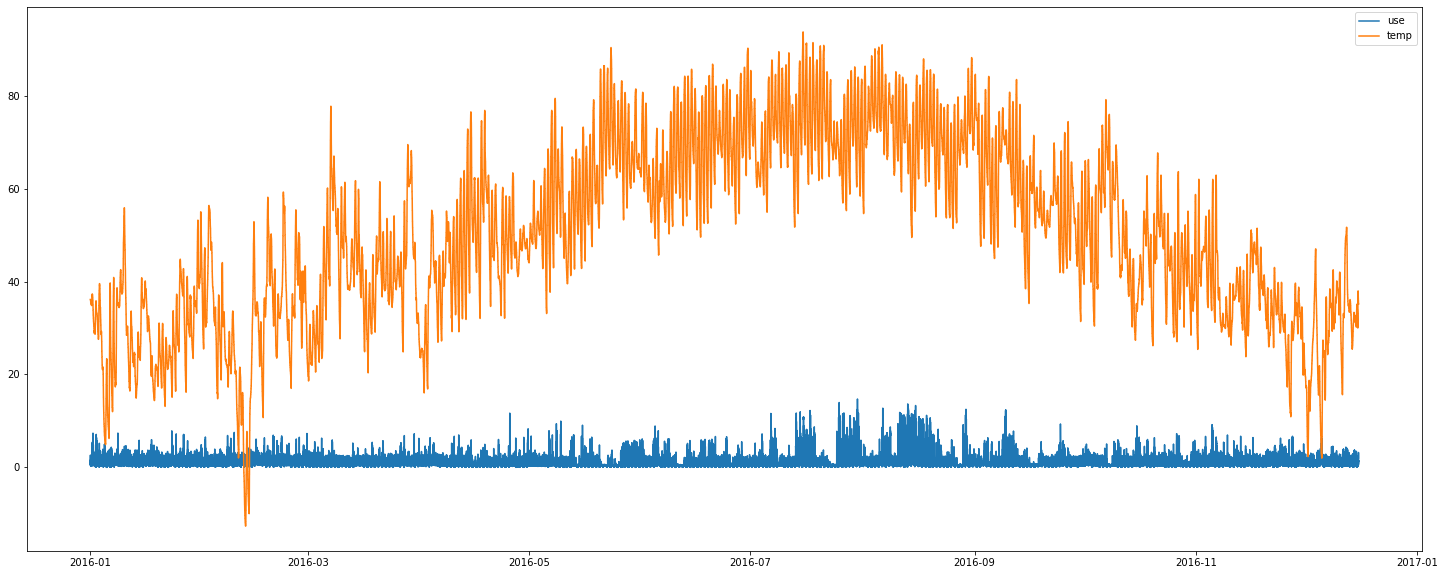

In [11]:
plt.figure(figsize=(25,10))
plt.plot(df['use'],label='use')
plt.plot(df['temperature'],label='temp')
plt.legend()
df.info()

2016-01-01    30.169358
2016-01-02    30.680708
2016-01-03    26.187171
2016-01-04    28.818997
2016-01-05    22.561987
                ...    
2016-12-11    25.590984
2016-12-12    27.150711
2016-12-13    16.241008
2016-12-14    20.486863
2016-12-15    23.036400
Freq: D, Name: use, Length: 350, dtype: float64

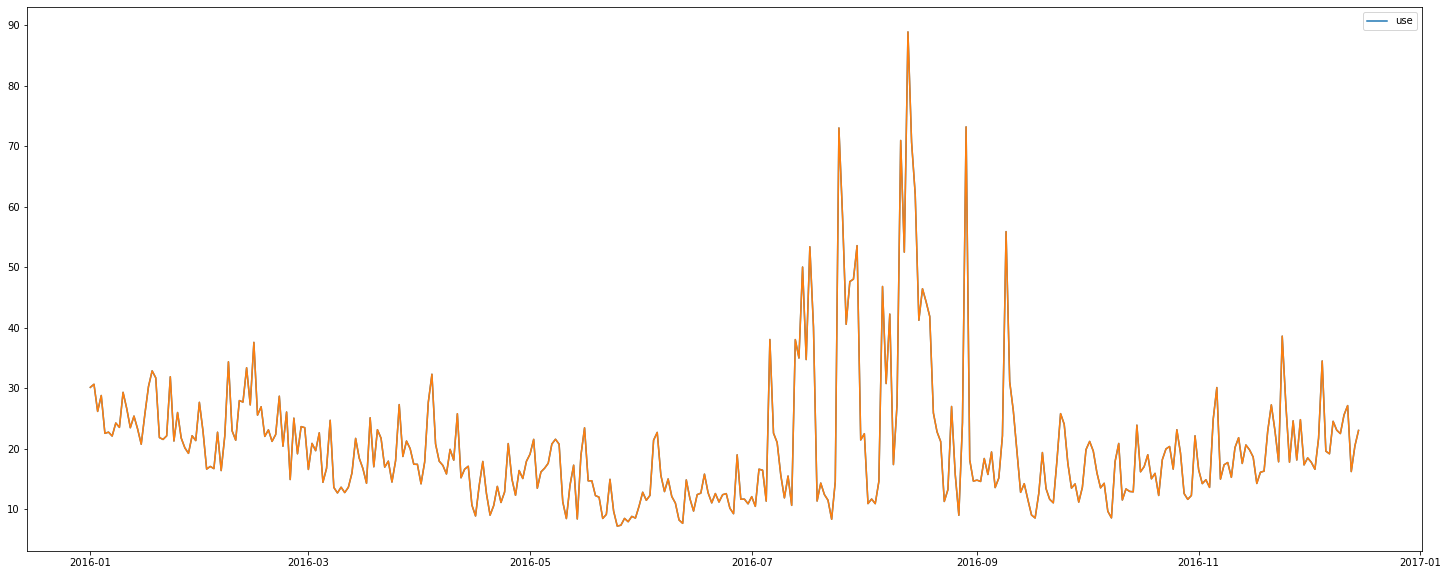

In [12]:
hour = df.resample('H').mean()
day = hour.resample('D').sum()
plt.figure(figsize=(25,10))
plt.plot(day['use'], label = 'use')
plt.legend()
plt.plot(day['use'])
day['use']

In [13]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)

In [14]:
def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()

In [15]:
def inverse_differencing(orig_data, diff_data, interval):
    output = orig_data[:interval].tolist()
    for i in range(interval, len(diff_data)):
        output.append(output[i-interval] + diff_data[i])
    return output

def inverse_differencing_forecast(orig_series, diff_series, forecast_series, interval):
    series_merge = diff_series.append(forecast_series)
    inverse_diff_series = pd.Series(inverse_differencing(orig_series, series_merge, interval), 
                                    index=series_merge.index)
    return inverse_diff_series[-len(forecast_series):]

def train_test_forecast_plot(train_series, test_series, forecast_series, lower_upper=None):
    plt.plot(train_series, label = 'train')
    plt.plot(test_series, label = 'test')
    plt.plot(forecast_series, label = 'forecast')

    if lower_upper is not None:
        plt.fill_between(lower_upper[0].index, lower_upper[0], 
                     lower_upper[1], color='k', alpha=.15)
    plt.legend()

# Energy Usage

In [16]:
day_use_ts = pd.Series(day.use.values, index = day.index)
day_use_ts

2016-01-01    30.169358
2016-01-02    30.680708
2016-01-03    26.187171
2016-01-04    28.818997
2016-01-05    22.561987
                ...    
2016-12-11    25.590984
2016-12-12    27.150711
2016-12-13    16.241008
2016-12-14    20.486863
2016-12-15    23.036400
Freq: D, Length: 350, dtype: float64

In [17]:
day['use'].shape

(350,)

In [18]:
day_use_ts.shape

(350,)

<Figure size 1800x720 with 0 Axes>

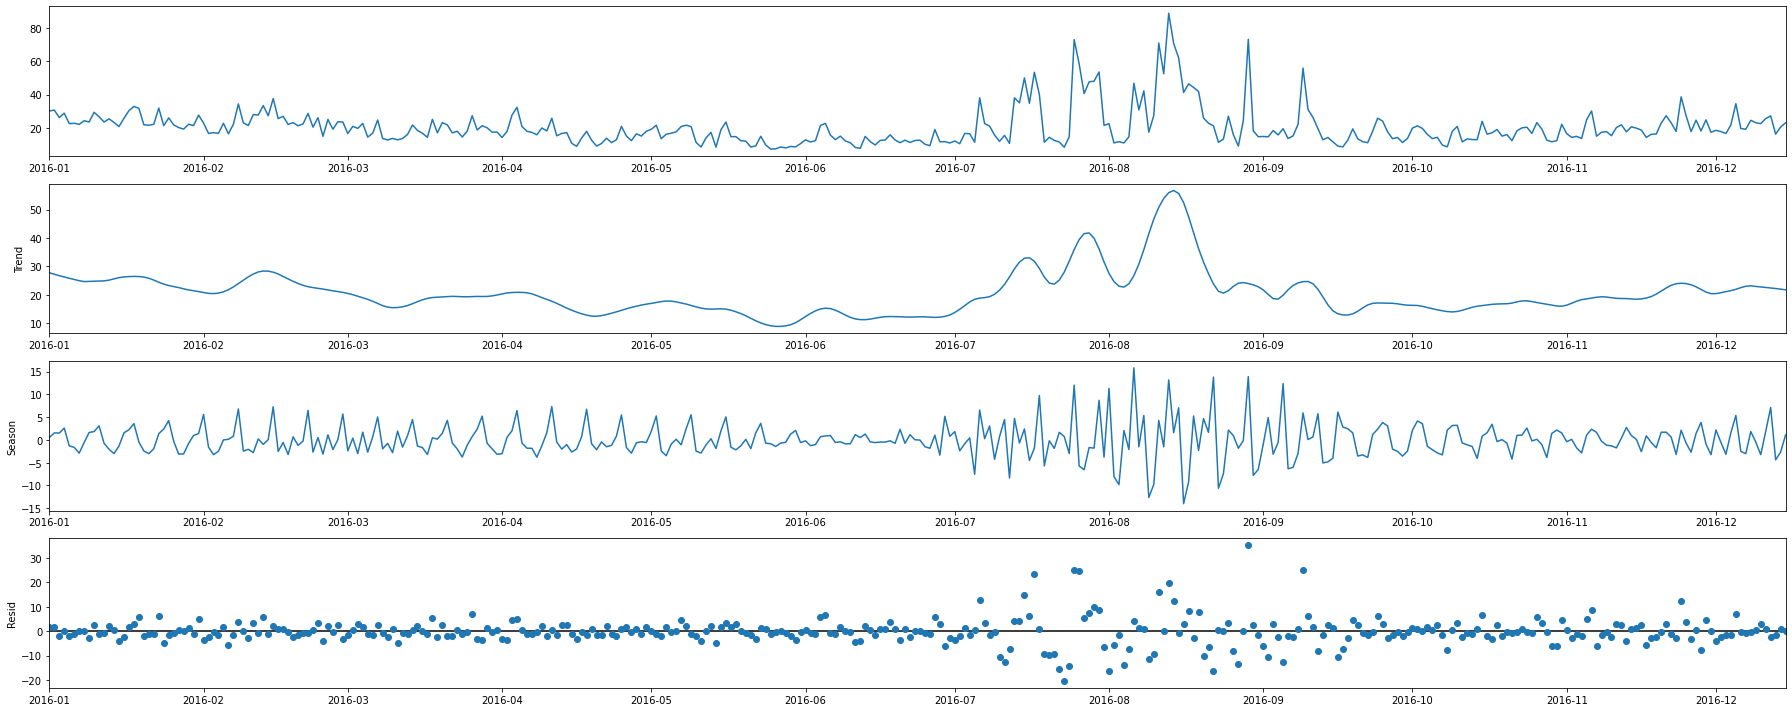

In [19]:
plt.rc('figure',figsize=(25,10))
use_stl = STL(day_use_ts).fit()
plt.figure(figsize=(25,10))
use_stl.plot()
plt.show()

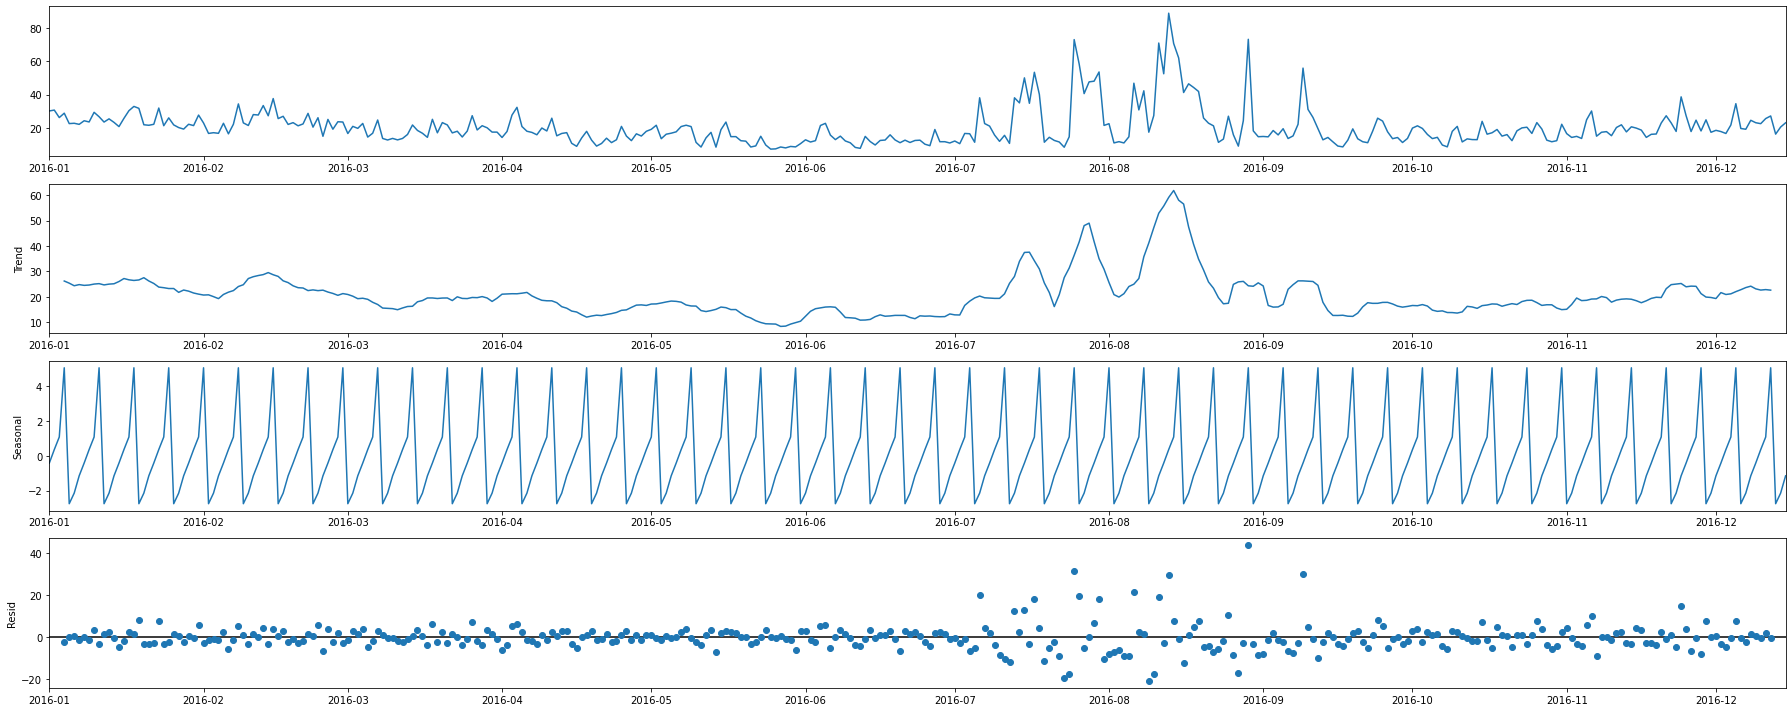

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
#perform decomposition
use_result = seasonal_decompose(day_use_ts, model='additive')
#plot results
use_result.plot()
plt.show()

In [21]:
# please perform a splitting to convert into train and test dataset
### BEGIN SOLUTION
use_split_ratio = round(day_use_ts.shape[0]*0.8)
train_use = day_use_ts.iloc[:use_split_ratio]
test_use = day_use_ts.iloc[use_split_ratio:]
### END SOLUTION

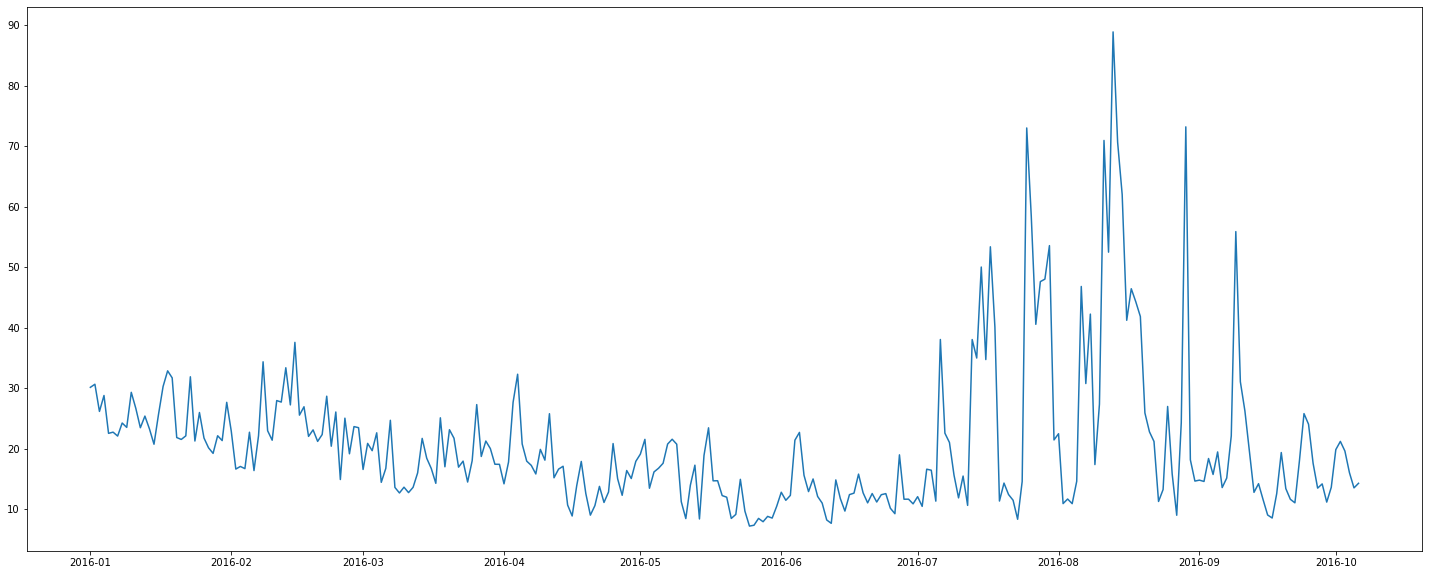

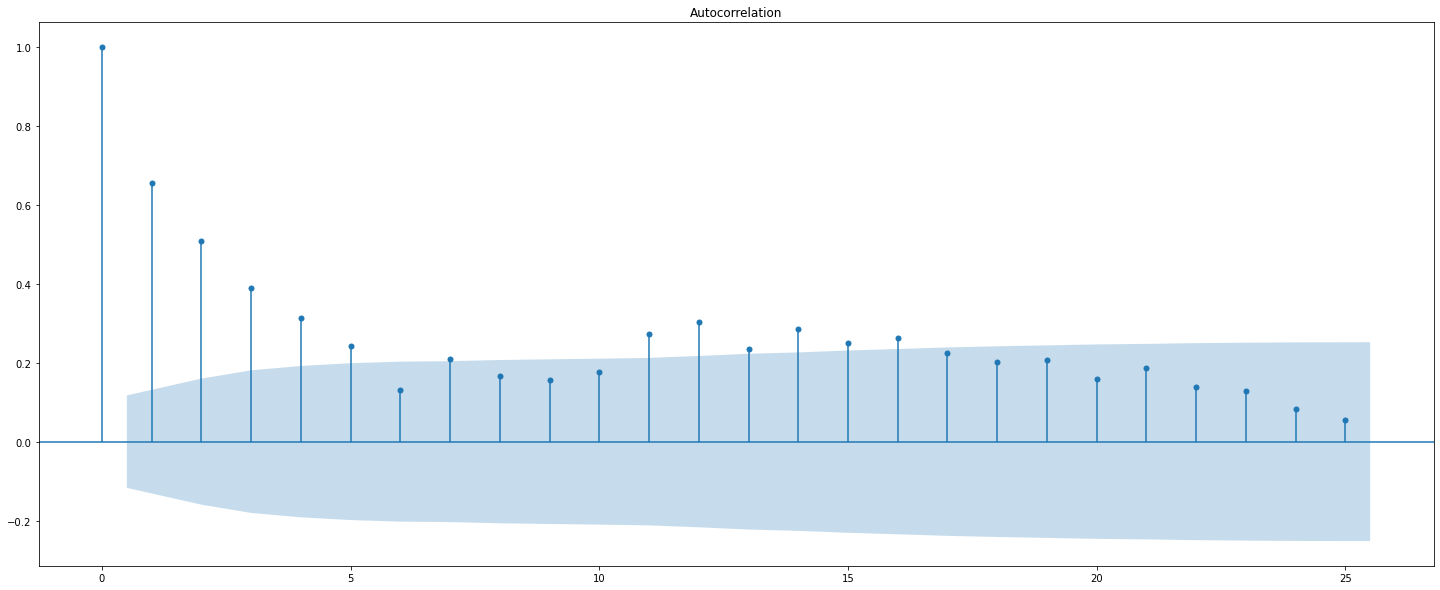

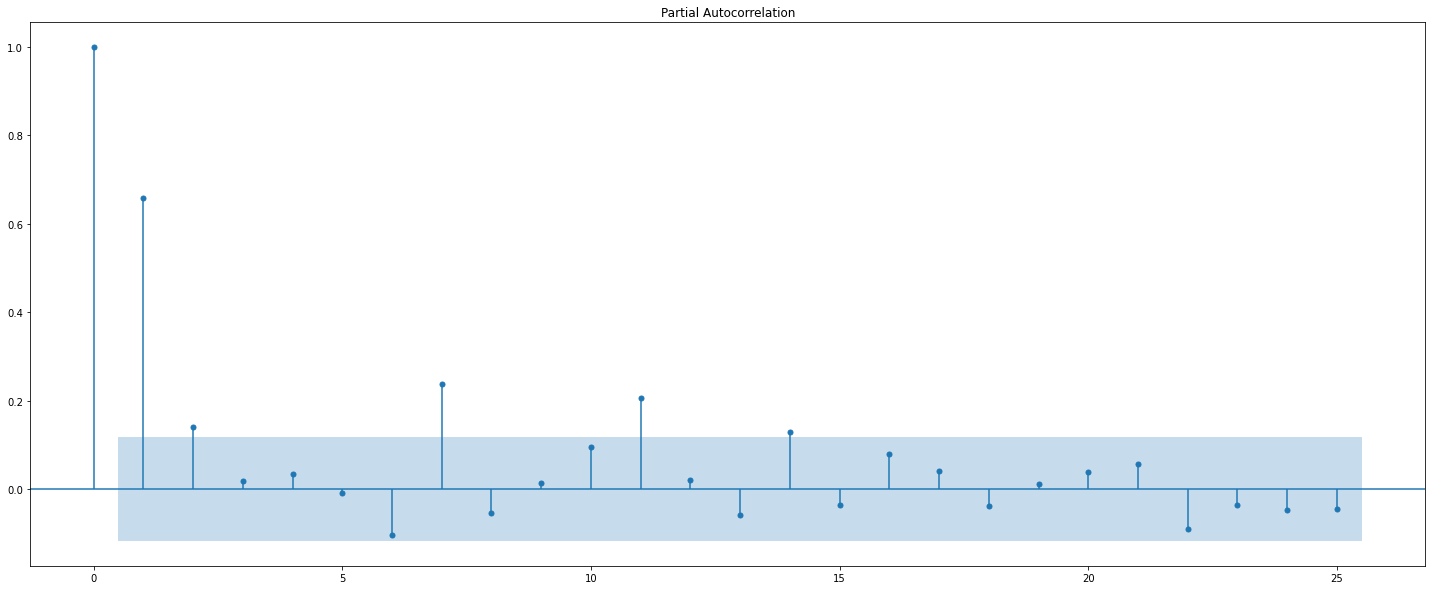

In [22]:
plt.plot(train_use)
plot_acf(train_use);
plot_pacf(train_use);
#pd.plotting.lag_plot(train_use, lag=60)
#plt.show()

In [23]:
result_use = adfuller(train_use)
print_adf_result(result_use)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.644771
P-Value                   0.084092
# Lags Used              10.000000
# Observations Used     269.000000
Critical Value (1%)      -3.454896
Critical Value (5%)      -2.872345
Critical Value (10%)     -2.572528
dtype: float64


In [24]:
train_use_diff = train_use.diff(6)
print_adf_result(adfuller(train_use_diff.dropna()))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -5.824163e+00
P-Value                 4.116416e-07
# Lags Used             1.200000e+01
# Observations Used     2.610000e+02
Critical Value (1%)    -3.455656e+00
Critical Value (5%)    -2.872678e+00
Critical Value (10%)   -2.572705e+00
dtype: float64


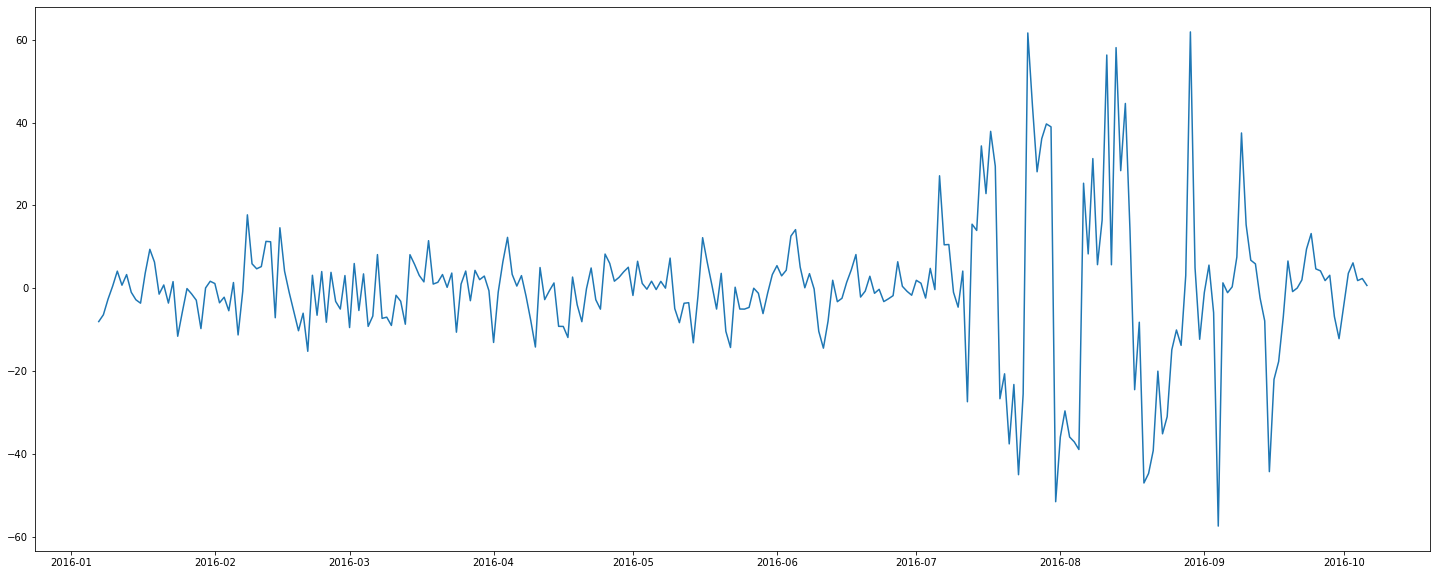

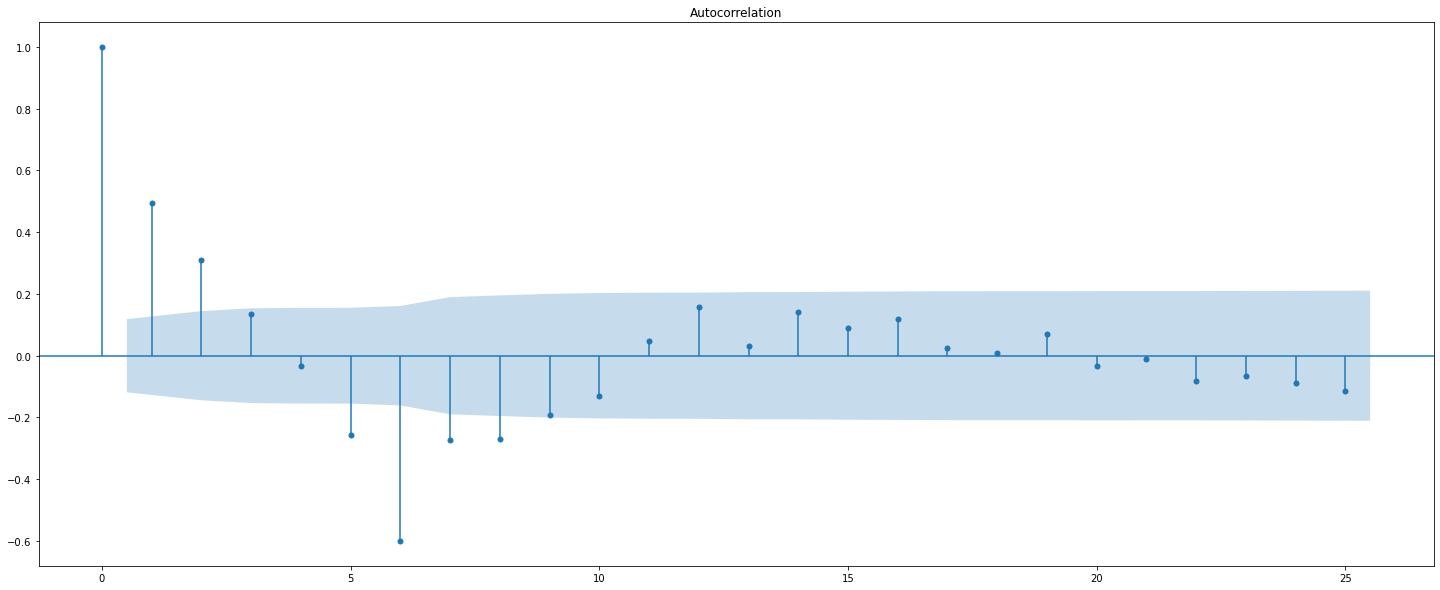

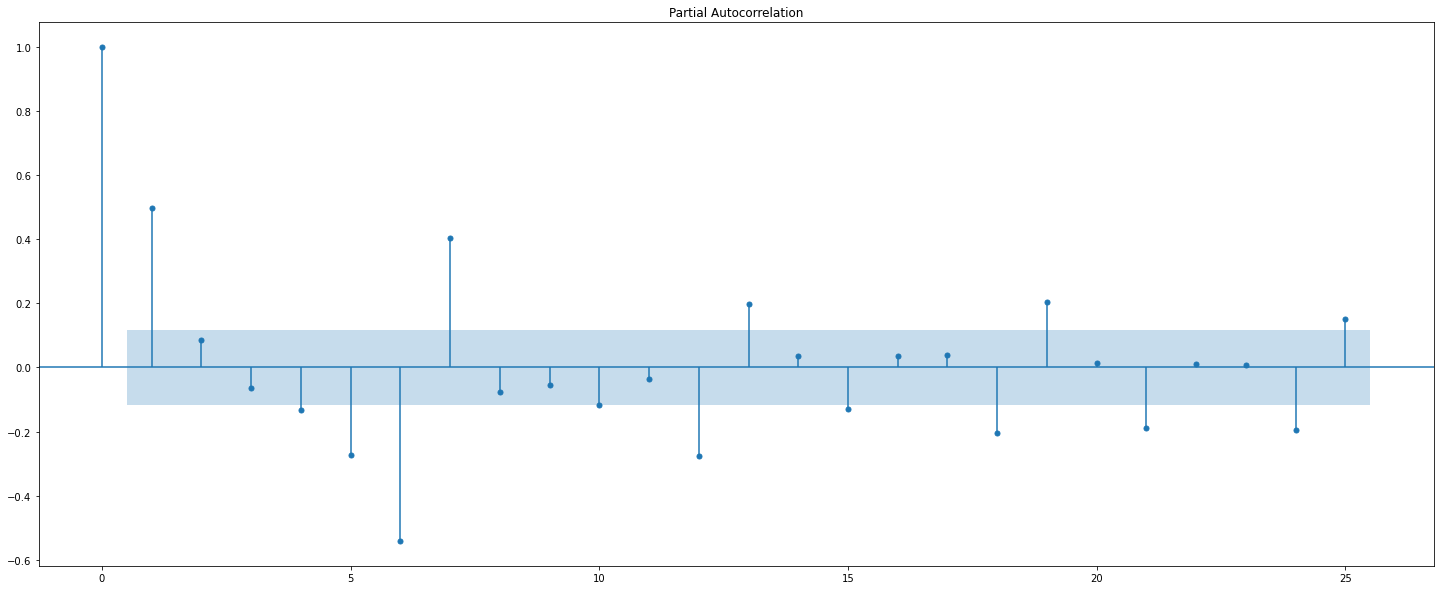

In [25]:
plt.figure(figsize=(25,10))
plt.plot(train_use_diff.dropna())
plot_acf(train_use_diff.dropna());
plot_pacf(train_use_diff.dropna());

In [26]:
arima_use = ARIMA(train_use_diff.dropna(), order=(6, 1, 2)).fit()
### END SOLUTION

# display summary of model
### BEGIN SOLUTION
arima_use.summary()
### END SOLUTION

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  273
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -1037.182
Method:                       css-mle   S.D. of innovations             10.635
Date:                Sun, 04 Apr 2021   AIC                           2094.364
Time:                        11:40:34   BIC                           2130.459
Sample:                    01-08-2016   HQIC                          2108.854
                         - 10-06-2016                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.010      0.063      0.950      -0.019       0.020
ar.L1.D.y     -0.0977      0.065     -1.509      0.131      -0.225       0.029
ar.L2.D.y      0.2763      0.051      5.414      0.000       0.176       0.376
ar.L3.D.y      0.0937      0.050      1.882      0.060      -0.004       0.191
ar.L4.D.y      0.0701      0.049      1.435      0.151      -0.026       0.166
ar.L5.D.y     -0.0436      0.047     -0.927      0.354      -0.136       0.049
ar.L6.D.y     -0.6266      0.046    -13.606      0.000      -0.717      -0.536
ma.L1.D.y     -0.4093      0.083     -4.953      0.000      -0.571      -0.247
ma.L2.D.y     -0.5907      0.082     -7.194      0.000      -0.752      -0.430
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9438           -0.4707j            1.0547           -0.4264
AR.2           -0.9438           +0.4707j            1.0547            0.4264
AR.3           -0.0497           -1.1196j            1.1207           -0.2571
AR.4           -0.0497           +1.1196j            1.1207            0.2571
AR.5            0.9587           -0.4725j            1.0688           -0.0729
AR.6            0.9587           +0.4725j            1.0688            0.0729
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6929           +0.0000j            1.6929            0.5000
-----------------------------------------------------------------------------
"""

In [27]:
residuals_use = pd.Series(arima_use.resid)

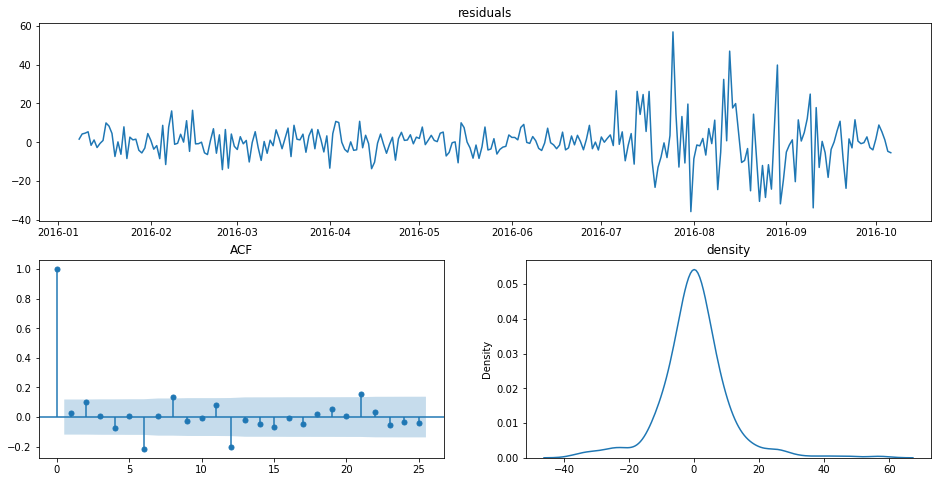

In [30]:
check_residuals(residuals_use)

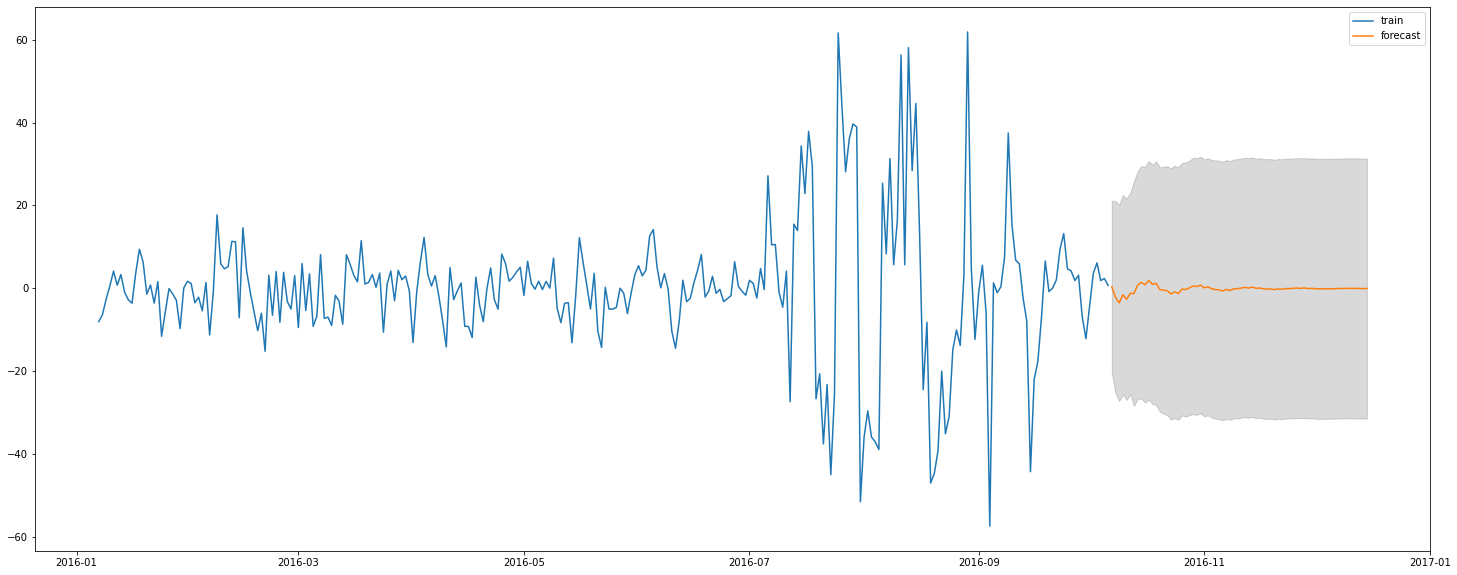

In [31]:
arima_use_forecast, se, conf = arima_use.forecast(len(day_use_ts)-use_split_ratio)

arima_use_forecast = pd.Series(arima_use_forecast, index=test_use.index)
lower_use_series = pd.Series(conf[:, 0], index=test_use.index)
upper_use_series = pd.Series(conf[:, 1], index=test_use.index)

plt.plot(train_use_diff, label='train')
plt.plot(arima_use_forecast, label='forecast')

plt.fill_between(lower_use_series.index, lower_use_series, upper_use_series, color='k', alpha=.15)
plt.legend()

In [32]:
# inverse differenced series back to original series
use_forecast_series = inverse_differencing_forecast(train_use, train_use_diff, arima_use_forecast, 6)
use_lower_series = inverse_differencing_forecast(train_use,  train_use_diff, lower_use_series, 6)
use_upper_series = inverse_differencing_forecast(train_use,  train_use_diff, upper_use_series, 6)

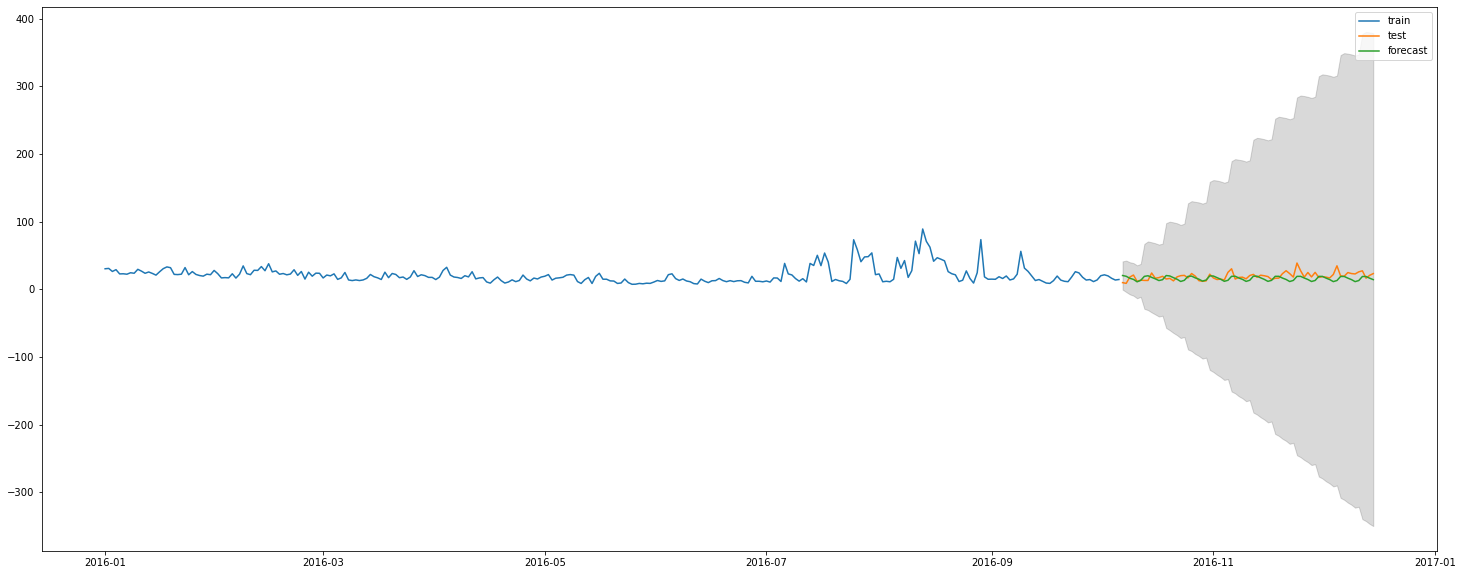

In [33]:
train_test_forecast_plot(train_use, test_use, use_forecast_series, 
                         [use_lower_series, use_upper_series])

In [34]:
mse = mean_squared_error(test_use, use_forecast_series)
print('Test MSE: ', mse)

Test MSE:  50.08844766591889


In [35]:
mae = mean_absolute_error(test_use, use_forecast_series)
print('Test MAE: ', mae)

Test MAE:  5.4823058523280475


In [36]:
rmse = np.sqrt(mse)
print("Test RMSE: ",rmse)

Test RMSE:  7.077319242899736


# ANOTHER ARIMA BUILD & FORECAST METHOD

In [37]:
def forcast_ts(data, tt_ratio):
    X = data.values
    size = int(len(X) * tt_ratio)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(6,1,2))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('progress:%',round(100*(t/len(test))),'\t predicted=%f, expected=%f' % (yhat, obs), end="\r")
    error = mean_squared_error(test, predictions)
    rerror = np.sqrt(error)
    print('\n Test MSE: %.3f' % error)
    print('\n Test RMSE: %.3f' % rerror)

In [38]:
forcast_ts(day_use_ts, 0.8)

progress:% 99 	 predicted=20.796462, expected=23.036400
 Test MSE: 31.019

 Test RMSE: 5.569


# GRID SEARCH BEST MODEL

In [46]:
param_p = [0,1,2,3,4,5,6,7,8,9,10]
param_d = [0,1] # ARIMA only support two times of differencing
param_q = [0,1,2,3,4,5]

In [47]:
best_error, best_params, best_model = None, None, None

for p in param_p:
    for d in param_d:
        for q in param_q:
            try:
                arima = ARIMA(train_use_diff.dropna(), order=(p,d,q)).fit()
                if best_error is None or arima.aic < best_error:
                    best_error = arima.aic
                    best_params = (p,d,q)
                    best_model = arima
                print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
            except:
                pass
print('Best Error={}, Best Params={}'.format(best_error, best_params))

ARIMA(0,0,0), AIC=2310.244093540041
ARIMA(0,0,1), AIC=2256.668900679295
ARIMA(0,0,2), AIC=2237.5799885094675
ARIMA(0,0,3), AIC=2200.7722815646875
ARIMA(0,0,4), AIC=2170.9836442722853
ARIMA(0,0,5), AIC=2076.7274751968434
ARIMA(0,1,0), AIC=2305.5893954883704
ARIMA(0,1,1), AIC=2274.0818290597213
ARIMA(0,1,2), AIC=2275.85428333495
ARIMA(0,1,3), AIC=2229.413638687252
ARIMA(0,1,4), AIC=2199.905800064128
ARIMA(0,1,5), AIC=2169.6466999929517
ARIMA(1,0,0), AIC=2235.620654498519
ARIMA(1,0,1), AIC=2236.1448893184415
ARIMA(1,0,2), AIC=2236.629036888644
ARIMA(1,0,3), AIC=2185.4462613223513
ARIMA(1,0,5), AIC=2060.2914978957742
ARIMA(1,1,0), AIC=2278.833786573123
ARIMA(1,1,1), AIC=2234.726030193991
ARIMA(1,1,2), AIC=2248.3430268345383
ARIMA(1,1,3), AIC=2205.584847352045
ARIMA(1,1,4), AIC=2207.617593335
ARIMA(1,1,5), AIC=2185.434352341689
ARIMA(2,0,0), AIC=2235.6156883450967
ARIMA(2,0,1), AIC=2237.277048555256
ARIMA(2,0,2), AIC=2199.5714338489497
ARIMA(2,0,3), AIC=2186.3362384816373
ARIMA(2,0,4), AIC=

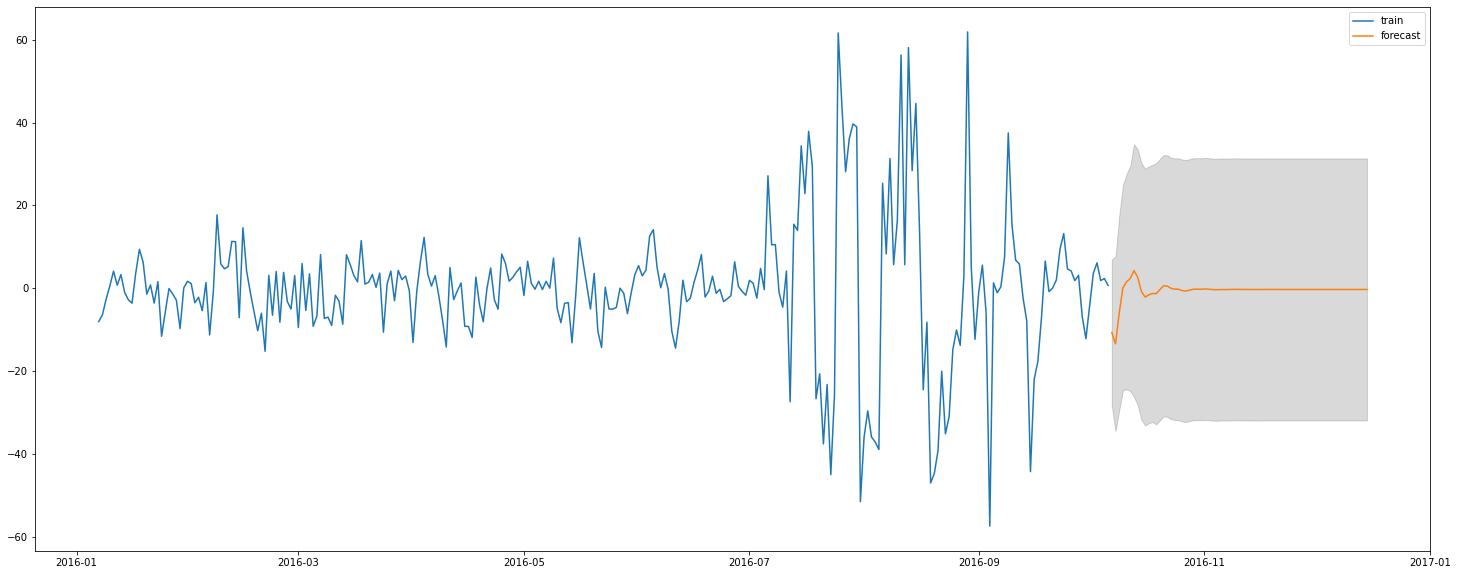

In [48]:
arima_forecast, se, conf = best_model.forecast(len(day_use_ts)-use_split_ratio)

arima_forecast = pd.Series(arima_forecast, index=test_use.index)
lower_series = pd.Series(conf[:, 0], index=test_use.index)
upper_series = pd.Series(conf[:, 1], index=test_use.index)

plt.plot(train_use_diff, label='train')
plt.plot(arima_forecast, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.legend()

In [49]:
# inverse differenced series back to original series
temp_forecast_series = inverse_differencing_forecast(train_use, train_use_diff, arima_forecast, 6)
temp_lower_series = inverse_differencing_forecast(train_use,  train_use_diff, lower_series, 6)
temp_upper_series = inverse_differencing_forecast(train_use,  train_use_diff, upper_series, 6)

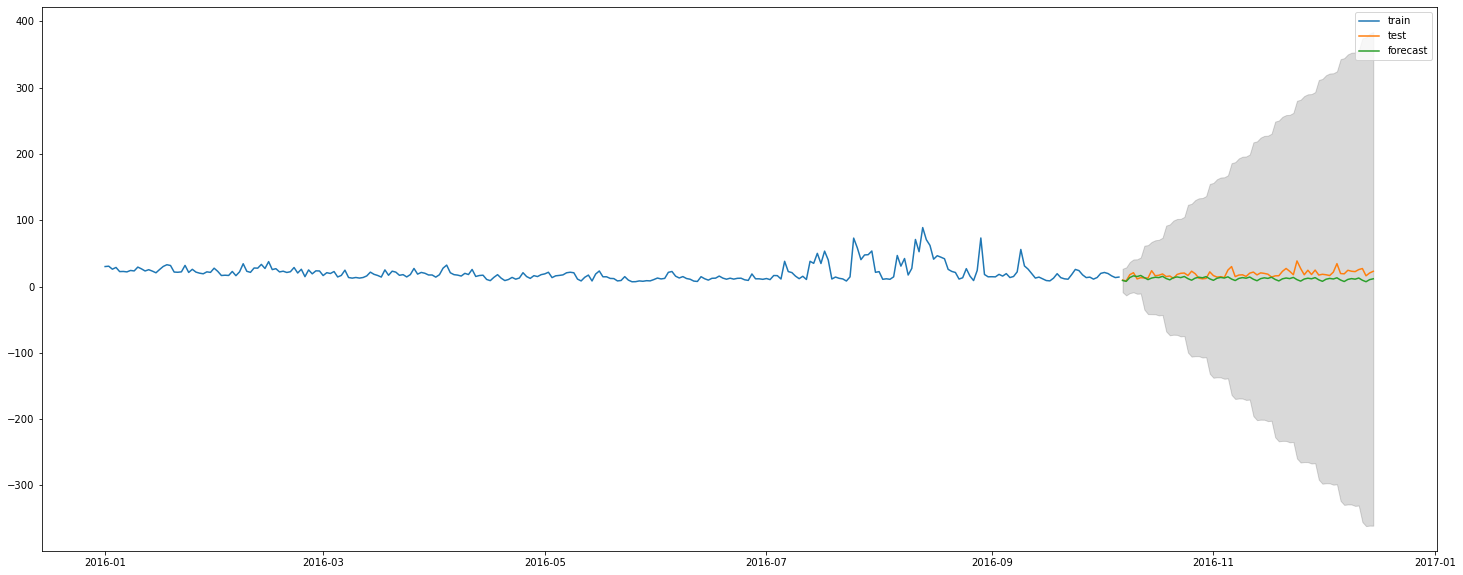

In [50]:
train_test_forecast_plot(train_use, test_use, temp_forecast_series, 
                         [temp_lower_series, temp_upper_series])

In [51]:
gs_mse = mean_squared_error(test_use, temp_forecast_series)
print('Test MSE: ', gs_mse)

Test MSE:  86.36267474467421


In [52]:
gs_mae = mean_absolute_error(test_use, use_forecast_series)
print('Test MAE: ', gs_mae)

Test MAE:  5.4823058523280475


In [53]:
gs_rmse = np.sqrt(gs_mse)
print('Test RMSE: ',gs_rmse)

Test RMSE:  9.293152034948864


# SARIMA

In [39]:
sarimax = SARIMAX(train_use_diff, order=(1,1,0), seasonal_order=(1,1,0,6)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  280
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 6)   Log Likelihood               -1203.731
Date:                           Sun, 04 Apr 2021   AIC                           2413.463
Time:                                   11:46:23   BIC                           2424.291
Sample:                               01-01-2016   HQIC                          2417.810
                                    - 10-06-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3068      0.040     -7.590      0.000      -0.386      -0.228
ar.S.L6       -0.7533      0.020    -38.363      0.000      -0.792      -0.715
sigma2       335.7860     15.882     21.143      0.000     304.658     366.914
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               500.99
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               9.69   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

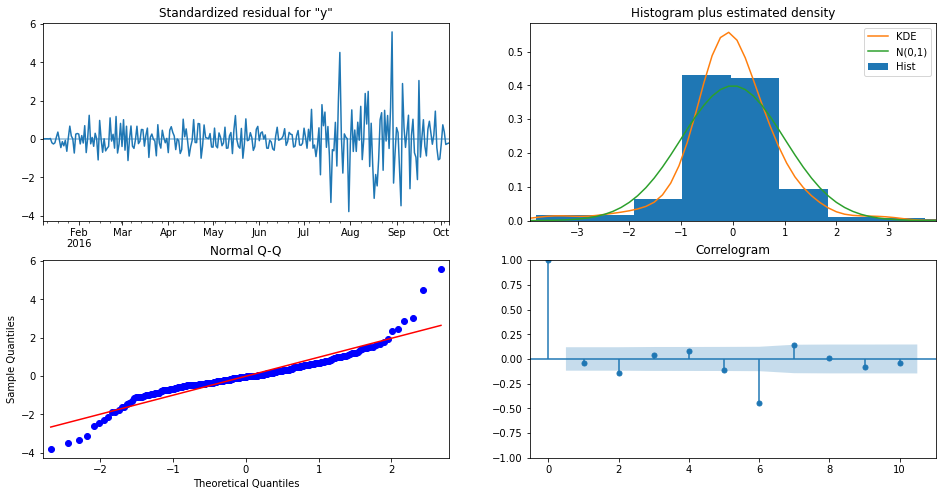

In [40]:
sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [41]:
sarimax_forecast = sarimax.get_forecast(len(day_use_ts)-use_split_ratio)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

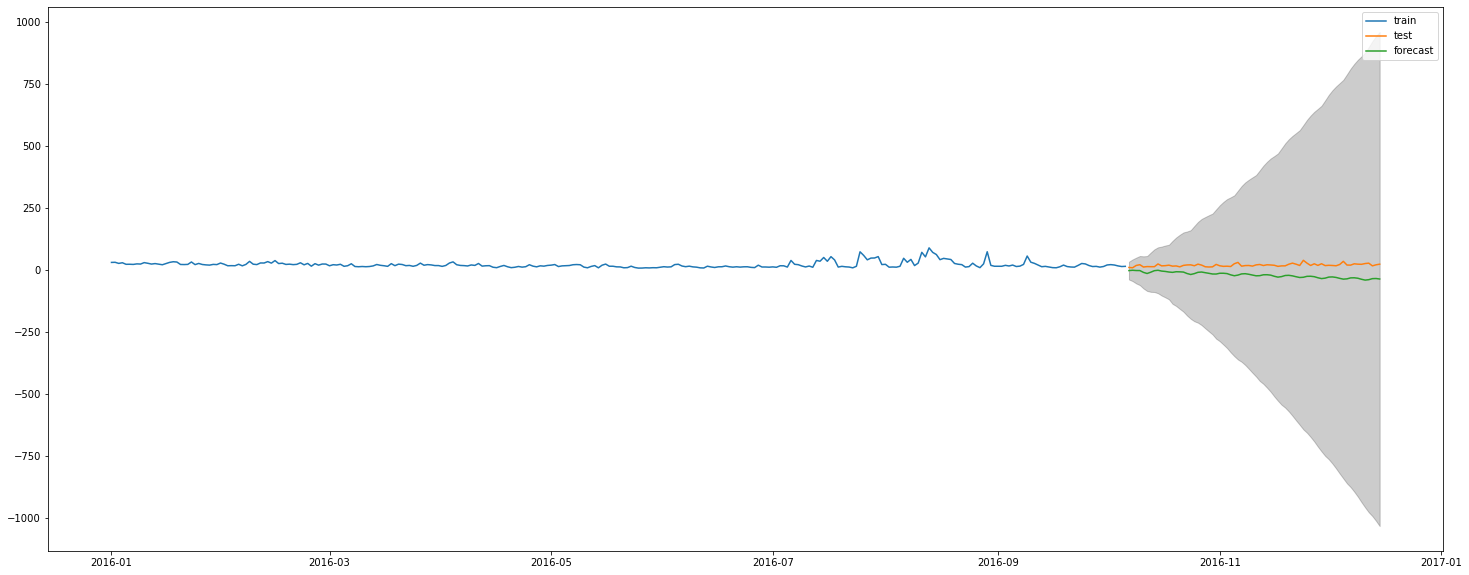

In [42]:
plt.plot(train_use, label='train')
plt.plot(test_use, label='test')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)
                 

plt.legend()


In [43]:
s_mae = mean_absolute_error(test_use, sarimax_forecast.predicted_mean)
print('Test MAE: ', s_mae)

Test MAE:  39.846971914863126


In [44]:
s_mse = mean_squared_error(test_use,sarimax_forecast.predicted_mean)
print('Test MSE: ',s_mse)

Test MSE:  1795.1285859170825


In [45]:
s_rmse = np.sqrt(s_mse)
print('Test RMSE: ',s_rmse)

Test RMSE:  42.36895781013598
